In [1]:
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy import linalg

import firedrake as fd
import hydrogym as gym

fd.utils.ScalarType

dtype('float64')

In [101]:
mesh = 'noack'
evec_dir = 'global-modes'
flow = gym.flow.Cylinder(Re=50, h5_file=f'{evec_dir}/steady.h5')
print(flow.dot(flow.q, flow.q))

212.8694587451277


In [102]:
# flow = gym.flow.Cylinder(Re=50, mesh_name=mesh, h5_file=f'../output/{mesh}-steady.h5')
qB = flow.q.copy(deepcopy=True)

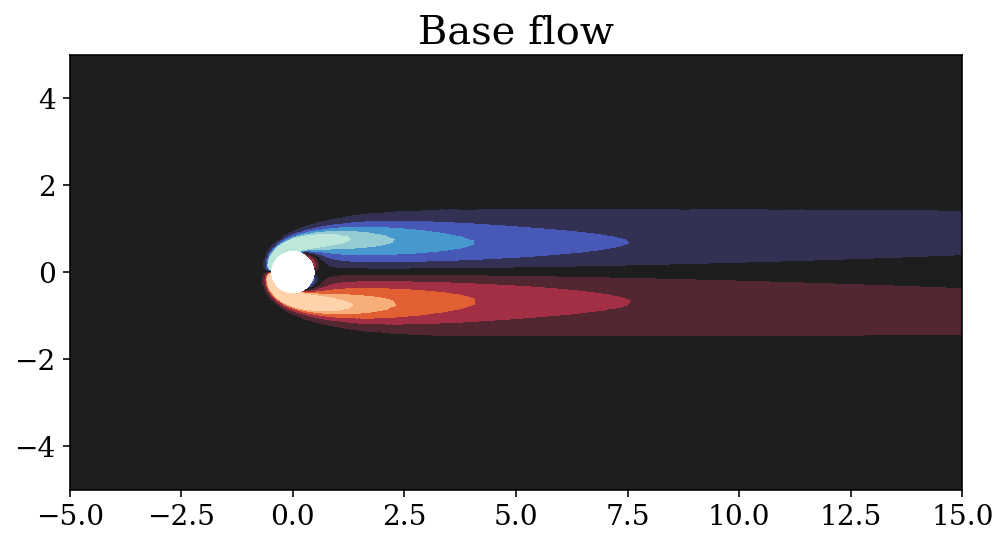

In [103]:
vort = flow.vorticity(u=qB.sub(0))
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-2, 2, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.title("Base flow")
plt.show()

0.001010671844368184


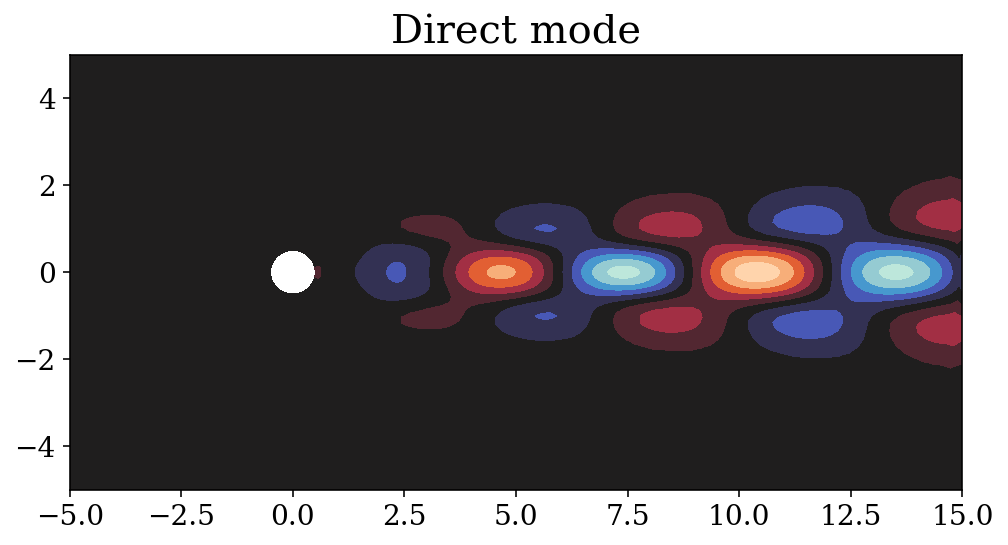

0.0004448831010786763


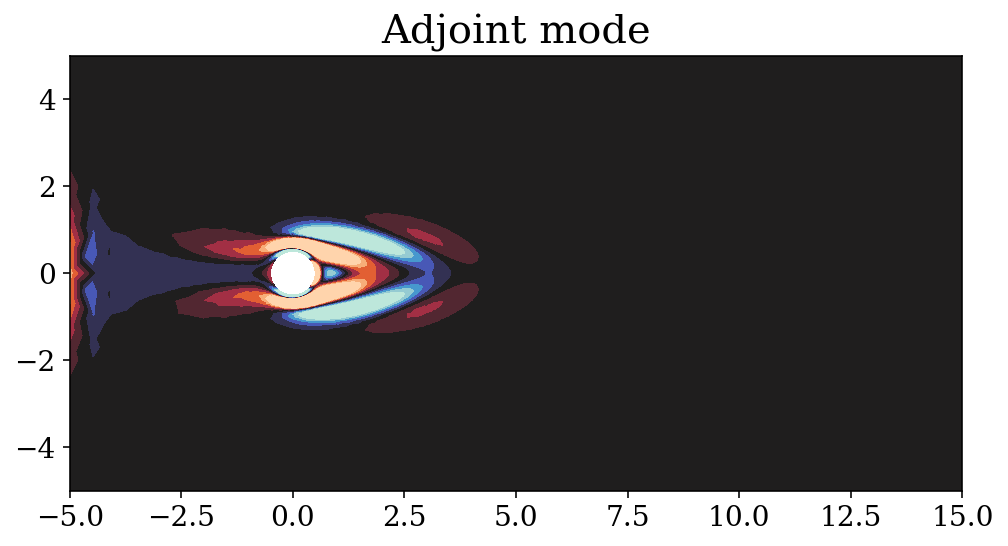

In [104]:
flow.load_checkpoint(f'{evec_dir}/direct_real.h5', idx=0, read_mesh=False)
print(flow.dot(flow.q, flow.q))
vort = flow.vorticity()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.title("Direct mode")
plt.show()

flow.load_checkpoint(f'{evec_dir}/adjoint_real.h5', idx=0, read_mesh=False)
print(flow.dot(flow.q, flow.q))
vort = flow.vorticity()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.title("Adjoint mode")
plt.show()

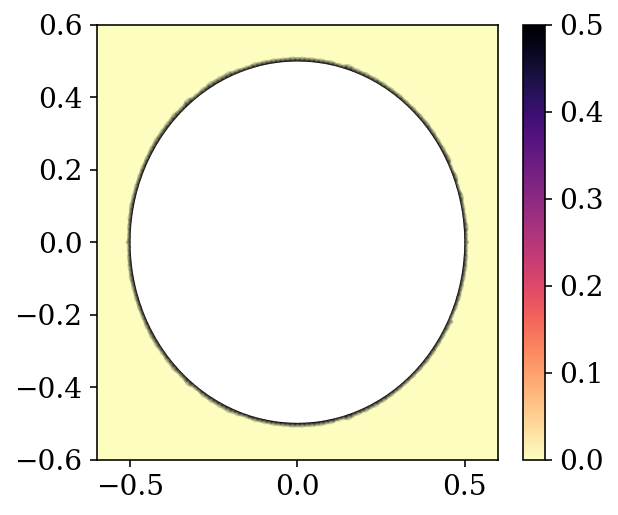

In [105]:
# Plot the control
B_fd = fd.Function(flow.mixed_space)
gym.utils.set_from_array(B_fd, B)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
Bu, Bp = B_fd.split()
im = fd.tripcolor(Bu, axes=ax, cmap='magma_r')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.6, 0.6])
plt.colorbar(im)

# Petrov-Galerkin projection

In [106]:
# Construct modal basis from real/imag parts
with flow.q.dat.vec_ro as vec:
    N = vec.size
V = np.zeros((N, 2))
W = np.zeros_like(V)

flow.load_checkpoint(f'{evec_dir}/direct_real.h5', idx=0, read_mesh=False)
V[:, 0] = gym.utils.get_array(flow.q)
    
flow.load_checkpoint(f'{evec_dir}/direct_imag.h5', idx=0, read_mesh=False)
V[:, 1] = gym.utils.get_array(flow.q)
    
flow.load_checkpoint(f'{evec_dir}/adjoint_real.h5', idx=0, read_mesh=False)
W[:, 0] = gym.utils.get_array(flow.q)

flow.load_checkpoint(f'{evec_dir}/adjoint_imag.h5', idx=0, read_mesh=False)
W[:, 1] = gym.utils.get_array(flow.q)

M = flow.mass_matrix(backend='scipy')

In [112]:
# Construct action of "A" and "C" on basis vectors
solver = gym.ts.IPCS(flow, dt=1e-2)
A, B = solver.linearize(qB)

r = 2
y_dim = 2
A_on_basis_vecs = np.zeros((N, r))
C_on_basis_vecs = np.zeros((y_dim, r))
for i in range(r):
    A_on_basis_vecs[:, i] = A * V[:, i]

    gym.utils.set_from_array(flow.q, V[:, i])
    C_on_basis_vecs[:, i] = flow.collect_observations()

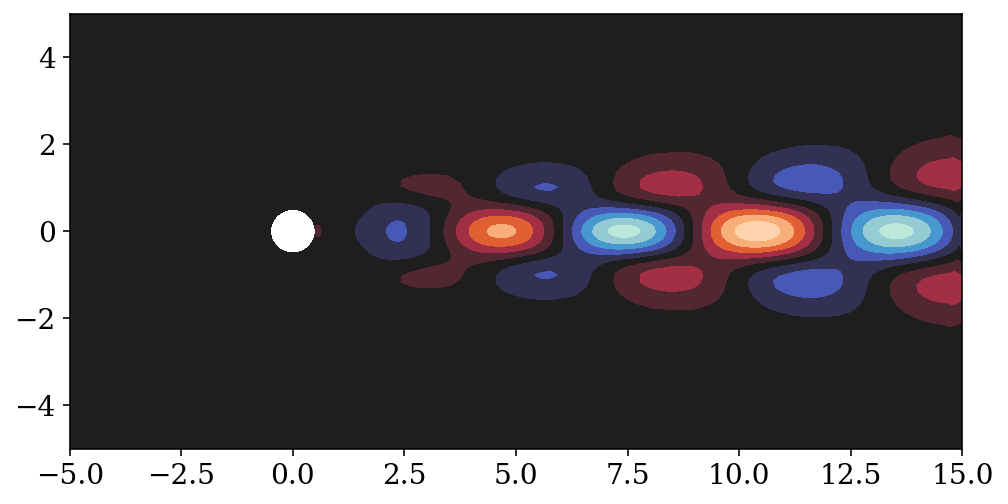

In [113]:
gym.utils.set_from_array(flow.q, A_on_basis_vecs[:, 0])
vort = flow.vorticity()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [117]:
P = linalg.inv(W.T @ M @ V) @ (W.T @ M)
Ar = P @ A_on_basis_vecs
Br = P @ B
Cr = C_on_basis_vecs

In [118]:
dt_evals, _ = linalg.eig(Ar)
np.log(dt_evals)/1e-2

array([0.02407713+0.8597384j, 0.02407713-0.8597384j])

# LQG design

In [119]:
import control

### Feedback control

In [120]:
Q = np.eye(r)
R = 1e8
K, _, ctrl_evals = control.dlqr(Ar, Br, Q, R)

np.log(ctrl_evals)/1e-2

array([-0.02407713+0.8597384j, -0.02407713-0.8597384j])

In [121]:
Br

array([[ 0.00069157],
       [-0.00069241]])

In [122]:
K

array([[ 0.68109434, -0.70886044]])

### Observer system

In [123]:
QN = 1e-6*np.eye(r)
RN = 1e-6*np.eye(y_dim)
GN = np.eye(r)

L, _, _ = control.dlqe(Ar, GN, Cr, QN, RN)

In [124]:
L

array([[-2.44966323e-01, -1.84335424e-05],
       [ 1.90391565e+00, -4.59694581e-05]])

In [125]:
Cr

array([[-8.27522961e-05,  1.09512083e-03],
       [-1.17161933e-08, -2.73869768e-08]])

### Test on ROM

In [134]:
Tf = 100
dt = 1e-2
n_steps = int(Tf//dt)

x = np.zeros((r, n_steps))
y = np.zeros((y_dim, n_steps))
x_hat = np.zeros((r, n_steps))
q = 1e-2*V[:, 0]

# Initialize
P = WV_inv @ (W.T @ M)
x[:, 0] = P @ (1e-2*V[:, 0])
# x_hat[:, 0] = x[:, 0]

for i in range(1, n_steps):
    x[:, i] = Ar @ x[:, i-1]
    y[:, i] = Cr @ x[:, i]
    
    err = y[:, i] - Cr @ x_hat[:, i-1]
    x_hat[:, i] = Ar @ x_hat[:, i-1] + L @ err
    
    print(i, x[:, i], y[:, i], x_hat[:, i], np.linalg.norm(err))

1 [ 1.00020424e-02 -8.59949695e-05] [-9.21866860e-07 -1.14830721e-10] [ 2.25826337e-07 -1.75515674e-06] 9.218668668760456e-07
2 [ 0.01000335 -0.00017202] [-1.01618799e-06 -1.12489889e-10] [ 4.59235926e-07 -3.68849688e-06] 1.014247200422385e-06
3 [ 0.01000391 -0.00025808] [-1.11047936e-06 -1.10139606e-10] [ 6.98642836e-07 -5.79969251e-06] 1.1064020167222741e-06
4 [ 0.01000373 -0.00034416] [-1.20473399e-06 -1.07780042e-10] [ 9.42462040e-07 -8.08838964e-06] 1.1983248150926361e-06
5 [ 0.01000282 -0.00043026] [-1.29894487e-06 -1.05411367e-10] [ 1.18910965e-06 -1.05542083e-05] 1.2900091227004528e-06
6 [ 0.01000116 -0.00051637] [-1.39310503e-06 -1.03033752e-10] [ 1.43700313e-06 -1.31967424e-05] 1.3814484949963345e-06
7 [ 0.00999876 -0.00060248] [-1.48720746e-06 -1.00647368e-10] [ 1.68456156e-06 -1.60155601e-05] 1.4726365161466108e-06
8 [ 0.00999562 -0.00068859] [-1.58124517e-06 -9.82523876e-11] [ 1.93020583e-06 -1.90102038e-05] 1.5635667994633648e-06
9 [ 0.00999174 -0.00077468] [-1.67521118e-

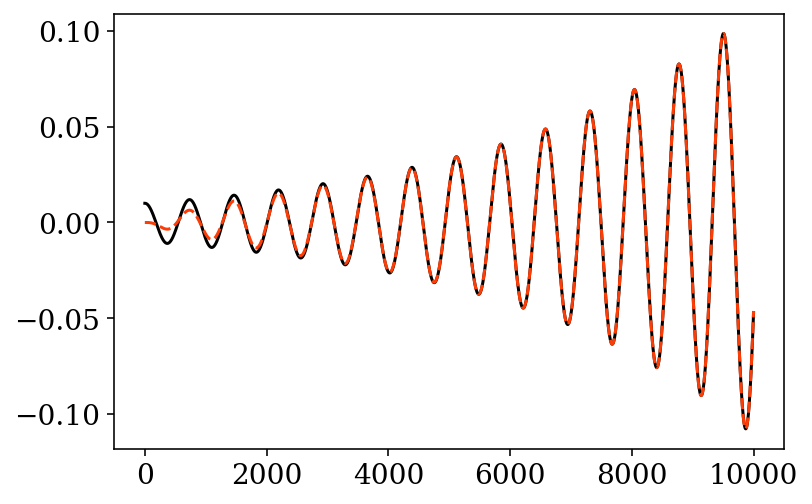

In [135]:
plt.plot(x[0, :], c='k')
plt.plot(x_hat[0, :], '--', c='xkcd:red orange')

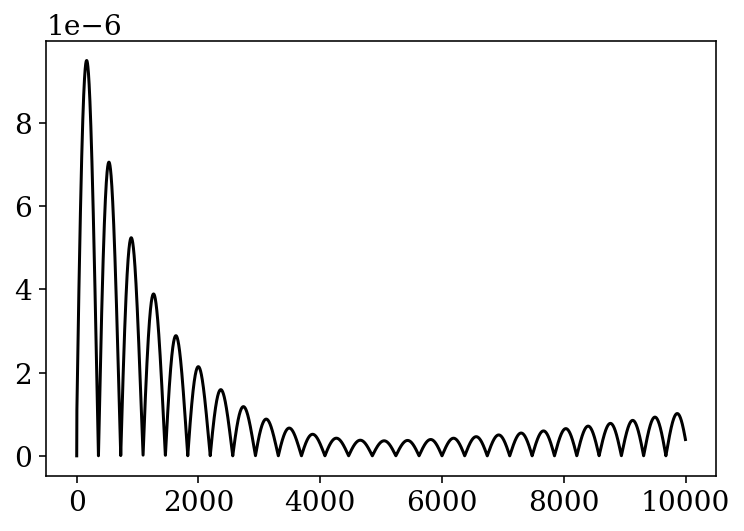

In [136]:
err =  y - Cr @ x_hat
# err = x - x_hat
plt.plot(np.sqrt(np.sum(err**2, axis=0)), c='k')

In [128]:
# With control

Tf = 100
dt = 1e-2
n_steps = int(Tf//dt)

x = np.zeros((r, n_steps))
y = np.zeros((y_dim, n_steps))
x_hat = np.zeros((r, n_steps))
q = 1e-2*V[:, 0]

# Initialize
P = WV_inv @ (W.T @ M)
x[:, 0] = P @ (1e-2*V[:, 0])
# x_hat[:, 0] = x[:, 0]

for i in range(1, n_steps):
    x[:, i] = Ar @ x[:, i-1] - Br @ (K @ x_hat[:, i-1])
    y[:, i] = Cr @ x[:, i]
    
    err = y[:, i] - Cr @ x_hat[:, i-1]
    x_hat[:, i] = Ar @ x_hat[:, i-1] + L @ err
    
    print(i, x[:, i], y[:, i], x_hat[:, i], np.linalg.norm(err))

1 [ 1.00020424e-02 -8.59949695e-05] [-9.21866860e-07 -1.14830721e-10] [ 2.25826337e-07 -1.75515674e-06] 9.218668668760456e-07
2 [ 0.01000334 -0.00017202] [-1.01618685e-06 -1.12489904e-10] [ 4.59235647e-07 -3.68849471e-06] 1.0142460603812514e-06
3 [ 0.01000391 -0.00025808] [-1.11047583e-06 -1.10139654e-10] [ 6.98641710e-07 -5.79968361e-06] 1.1063984831372573e-06
4 [ 0.01000373 -0.00034416] [-1.20472669e-06 -1.07780141e-10] [ 9.42459204e-07 -8.08836684e-06] 1.19831752157932e-06
5 [ 0.01000281 -0.00043025] [-1.29893232e-06 -1.05411537e-10] [ 1.18910394e-06 -1.05541616e-05] 1.2899965906025784e-06
6 [ 0.01000114 -0.00051635] [-1.39308561e-06 -1.03034015e-10] [ 1.43699308e-06 -1.31966588e-05] 1.3814291340253359e-06
7 [ 0.00999874 -0.00060245] [-1.48717947e-06 -1.00647749e-10] [ 1.68454539e-06 -1.60154233e-05] 1.4726086250507186e-06
8 [ 0.00999559 -0.00068855] [-1.58120679e-06 -9.82529121e-11] [ 1.93018147e-06 -1.90099940e-05] 1.5635285667261129e-06
9 [ 0.0099917  -0.00077464] [-1.67516046e-0

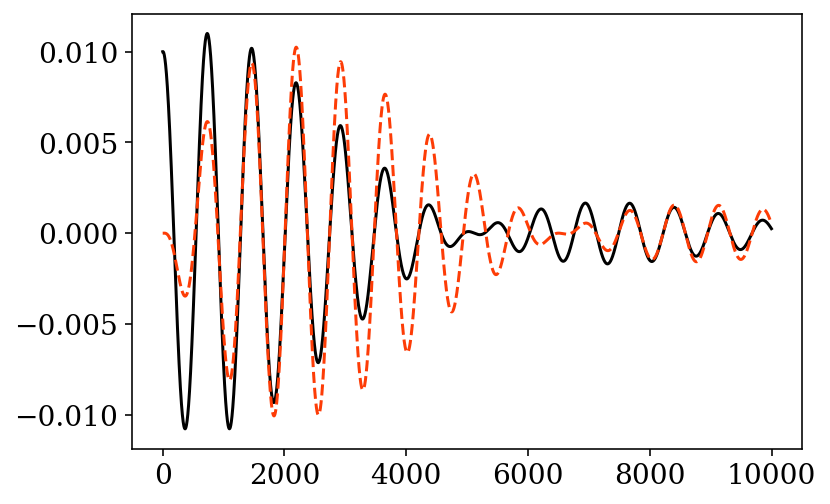

In [129]:
plt.plot(x[0, :], c='k')
plt.plot(x_hat[0, :], '--', c='xkcd:red orange')

# Load results from LTI timestepping